# 21cm Line Emission Simulations using RASCIL

## This notebook demonstrates how to run a 21cm line emission simulation, to obtain visibilities and dirty images, and create a mosaic of pointings with and without primary beams.

In [28]:
!export HDF5_USE_FILE_LOCKING='FALSE'

In [29]:
from datetime import datetime, timedelta
from pathlib import Path

import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from typing import List
from ska_sdp_datamodels.image.image_model import Image as RASCILImage
import matplotlib.pyplot as plt


from karabo.data.external_data import HISourcesSmallCatalogDownloadObject
from karabo.imaging.image import Image, ImageMosaicker
from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.imaging.imager_rascil import RascilDirtyImager, RascilDirtyImagerConfig
from karabo.simulation.interferometer import FilterUnits, InterferometerSimulation
from karabo.simulation.line_emission import (
    CircleSkyRegion,
    line_emission_pipeline,
    generate_gaussian_beam_data,
    gaussian_beam_fwhm_for_frequency,
)
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulator_backend import SimulatorBackend
from karabo.util.file_handler import FileHandler

In [30]:
# Image details
npixels = 2048
image_width_degrees = 3
cellsize_radians = np.radians(image_width_degrees) / npixels

# The number of time steps is then determined as total_length / integration_time.
observation_length = timedelta(seconds=10000)  # 14400 = 4hours
integration_time = timedelta(seconds=10000)

output_base_directory = Path(
    FileHandler().get_tmp_dir(
        prefix="line-emission-",
        purpose="Example line emission simulation",
    )
)

Creating /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE for Example line emission simulation


In [ ]:
# Define observation pointings
pointings = [
    CircleSkyRegion(
        radius=2 * u.deg, center=SkyCoord(ra=20, dec=-30, unit="deg", frame="icrs")
    ),
    CircleSkyRegion(
        radius=2 * u.deg,
        center=SkyCoord(ra=20, dec=-31.4, unit="deg", frame="icrs"),
    ),
    CircleSkyRegion(
        radius=2 * u.deg,
        center=SkyCoord(ra=21.4, dec=-30, unit="deg", frame="icrs"),
    ),
    CircleSkyRegion(
        radius=2 * u.deg,
        center=SkyCoord(ra=21.4, dec=-31.4, unit="deg", frame="icrs"),
    ),
]

In [32]:
# Primary beam settings
should_apply_primary_beam = False

# Create interferometer simulation
if should_apply_primary_beam:
    beam_type = "Gaussian beam"
    # Options: "Aperture array", "Isotropic beam", "Gaussian beam", "VLA (PBCOR)"
    gaussian_fwhm = 50  # Degrees
    gaussian_ref_freq = 8e8  # Hz
else:
    beam_type = "Isotropic beam"
    gaussian_fwhm = 0
    gaussian_ref_freq = 0

In [33]:
# Load sky with sources
sky = SkyModel.sky_test_LE()

In [34]:
# Define observation channels and duration
observation = Observation(
    start_date_and_time=datetime(2000, 3, 20, 12, 6, 39),
    length=observation_length,
    number_of_time_steps=int(
        observation_length.total_seconds() / integration_time.total_seconds()
    ),
    start_frequency_hz=7.1e8,   #start of redshift-bin you want to measure
    frequency_increment_hz=2e7,
    number_of_channels=4,       #on how many frequency channels you want to observe
)

In [35]:
# Instantiate interferometer       
interferometer = InterferometerSimulation(
    time_average_sec=10,
    ignore_w_components=True,
    uv_filter_max=10000,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    station_type="Isotropic beam",
    gauss_beam_fwhm_deg=0,
    gauss_ref_freq_hz=0,
    use_dask=False,
)

## Simulation: compute visibilities and dirty images (first, without primary beam effects)

In [36]:
# Run pipeline which computes the visibilities and dirty images
backend_to_dirty_images = {}

dirty_imager_config = RascilDirtyImagerConfig(
    imaging_npixel=npixels,
    imaging_cellsize=cellsize_radians,
)

for simulator_backend, telescope_name in (
    (SimulatorBackend.RASCIL, "MID"),
):
    telescope = Telescope.constructor(telescope_name, backend=simulator_backend)

    visibilities, dirty_images = line_emission_pipeline(
        output_base_directory=output_base_directory,
        pointings=pointings,
        sky_model=sky,
        observation_details=observation,
        telescope=telescope,
        interferometer=interferometer,
        simulator_backend=simulator_backend,
        dirty_imager_config=dirty_imager_config,
        primary_beams=None,
    )

    backend_to_dirty_images[simulator_backend] = dirty_images


print("Done with line emission pipelines")


# To use OSKAR change RascilDirtyImagerConfig to DirtyImagerConfig and SimulatorBackend.RASCIL to SimulatorBackend.OSKAR

Selected backend: SimulatorBackend.RASCIL
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...


Matched path /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE/visibilities_f0_p0.MS to format MS
Processing frequency channel 1...
Processing pointing 0...
Matched path /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE/visibilities_f1_p0.MS to format MS
Processing frequency channel 2...
Processing pointing 0...
Matched path /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE/visibilities_f2_p0.MS to format MS
Processing frequency channel 3...
Processing pointing 0...
Matched path /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE/visibilities_f3_p0.MS to format MS
Creating dirty images from visibilities...
Processing frequency channel 0...
Processing pointing 0...
Processing frequency channel 1...
Processing pointing 0...
Processing frequency channel 2...
Processing pointing 0...
Processing frequency channel 3...
Processing pointing 0...
Done with line emission pipelines


## Visualization of dirty images (and mosaics)

In [37]:
# Create mosaics of pointings for each frequency channel
mosaicker = ImageMosaicker()

backend_to_mosaics = {}

for simulator_backend, dirty_images in backend_to_dirty_images.items():
    print(f"Computing mosaic for  simulator_backend = { simulator_backend.name }")
    backend_to_mosaics[simulator_backend] = []

    for index_freq in range(observation.number_of_channels):
        mosaic, _ = mosaicker.mosaic(dirty_images[index_freq])
        backend_to_mosaics[simulator_backend].append(mosaic)


# Add all mosaics across frequency channels to create one final mosaic image
backend_to_summed_mosaics = {}

for simulator_backend, mosaics in backend_to_mosaics.items():
    summed_mosaic = Image(
        data=sum(m.data for m in mosaics),
        header=mosaics[0].header,
    )
    backend_to_summed_mosaics[simulator_backend] = summed_mosaic

Computing mosaic for  simulator_backend = RASCIL
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-KgxSGjaQWL for restored fits-path
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-CZQexCV2Xa for restored fits-path
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-0yWI9qK7qT for restored fits-path
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-u0eFzICZS3 for restored fits-path
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-Htiu7U31Nh for restored fits-path


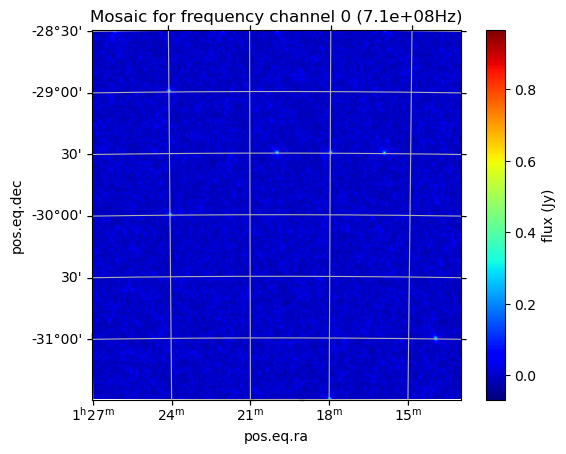

In [38]:
%matplotlib inline
#Plot the mosaic for the first frequency channel
backend_to_mosaics[SimulatorBackend.RASCIL][0].plot(
    block=True,
    title=f"Mosaic for frequency channel 0 ({observation.start_frequency_hz:.1e}Hz)",
)

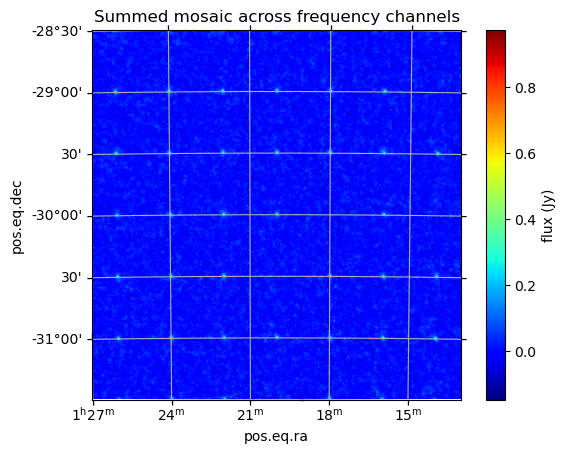

In [39]:
%matplotlib inline
#Plot the mosaics summed over all frequency channels
backend_to_summed_mosaics[SimulatorBackend.RASCIL].plot(
    block=True,
    title="Summed mosaic across frequency channels"
)

# Primary Beam Effects

## We instantiate different interferometers (with / without primary beam effects), and provide primary beams (Gaussian, in this example) to the `line_emission_pipeline`

## NOTE!
- RASCIL ignores the `gaussian_*` parameters in `InterferometerSimulation`, and instead uses the `primary_beams` array provided into `line_emission_pipeline`

In [40]:
# Instantiate interferometers
interferometer = InterferometerSimulation(
    time_average_sec=10,
    ignore_w_components=True,
    uv_filter_max=10000,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    station_type="Isotropic beam",
    gauss_beam_fwhm_deg=0,
    gauss_ref_freq_hz=0,
    use_dask=False,
)

# If you want to work with OSKAR you need to change the station_type to "Gaussian beam" and change the parameters gauss_beam_fwhm_deg=2 and gauss_ref_freq=7e8

## Generate data for primary beams (2D np.array for each frequency channel)
### RASCIL supports custom primary beams -> here, we use Gaussian beams
### For OSKAR the primary beam is created in the InterferometerSimulation

In [41]:
primary_beams: List[RASCILImage] = []

# Compute frequency channels
frequency_channel_starts = np.linspace(
    observation.start_frequency_hz,
    observation.start_frequency_hz
    + observation.frequency_increment_hz * observation.number_of_channels,
    num=observation.number_of_channels,
    endpoint=False,
)

In [42]:
# Here we create a sample beam (Gaussian)
# as a 2D np.array of shape (npixels, npixels)

for frequency in frequency_channel_starts:
    fwhm_degrees = gaussian_beam_fwhm_for_frequency(frequency)
    fwhm_pixels = fwhm_degrees / np.degrees(dirty_imager_config.imaging_cellsize)
    primary_beam = generate_gaussian_beam_data(
        fwhm_pixels=fwhm_pixels,
        x_size=dirty_imager_config.imaging_npixel,
        y_size=dirty_imager_config.imaging_npixel,
    )
    primary_beams.append(primary_beam)

To create a primary beam using eidos 'from eidos_beam_generator import eidos_beam_generator' und then convert the fits into 2D np.arrays

## We then run the simulations with and without primary beams, and compare the resulting dirty images

In [43]:
backend_to_dirty_images_without_primary_beams = {}

for simulator_backend, telescope_name in (
    (SimulatorBackend.RASCIL, "MID"), # For OSKAR change to SimulatorBackend.OSKAR
):
    telescope = Telescope.constructor(telescope_name, backend=simulator_backend)

    # Compute visibilities without primary beam

    (
        visibilities_without_primary_beam,
        dirty_images_without_primary_beam
    ) = line_emission_pipeline(
        output_base_directory=output_base_directory,
        pointings=pointings,
        sky_model=sky,
        observation_details=observation,
        telescope=telescope,
        interferometer=interferometer,
        simulator_backend=simulator_backend,
        dirty_imager_config=dirty_imager_config,
        primary_beams=None,
    )

    backend_to_dirty_images_without_primary_beams[
        simulator_backend
    ] = dirty_images_without_primary_beam

Selected backend: SimulatorBackend.RASCIL
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...
Matched path /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE/visibilities_f0_p0.MS to format MS
Processing frequency channel 1...
Processing pointing 0...
Matched path /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE/visibilities_f1_p0.MS to format MS
Processing frequency channel 2...
Processing pointing 0...
Matched path /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE/visibilities_f2_p0.MS to format MS
Processing frequency channel 3...
Processing pointing 0...
Matched path /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE/visibilities_f3_p0.MS to format MS
Creating dirty images from visibilities...
Processing frequency channel 0...
Processing pointing 0...
Processing frequency channel 1...
Processing pointing 0...
Pro

In [44]:
# Compute visibilities with primary beams

backend_to_dirty_images_with_primary_beams ={}

(
        visibilities_with_primary_beam,
        dirty_images_with_primary_beam
    ) = line_emission_pipeline(
        output_base_directory=output_base_directory,
        pointings=pointings,
        sky_model=sky,
        observation_details=observation,
        telescope=telescope,
        interferometer=interferometer,
        simulator_backend=simulator_backend,
        dirty_imager_config=dirty_imager_config,
        primary_beams=primary_beams,
    )

backend_to_dirty_images_with_primary_beams[
        simulator_backend
    ] = dirty_images_with_primary_beam

Selected backend: SimulatorBackend.RASCIL
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...
Matched path /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE/visibilities_f0_p0.MS to format MS
Processing frequency channel 1...
Processing pointing 0...
Matched path /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE/visibilities_f1_p0.MS to format MS
Processing frequency channel 2...
Processing pointing 0...
Matched path /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE/visibilities_f2_p0.MS to format MS
Processing frequency channel 3...
Processing pointing 0...
Matched path /tmp/karabo-STM-chiara-kttEaP1aVk/line-emission-bWSEXhOlTE/visibilities_f3_p0.MS to format MS
Creating dirty images from visibilities...
Processing frequency channel 0...
Processing pointing 0...
Processing frequency channel 1...
Processing pointing 0...
Pro

In [45]:
# Create mosaics of pointings for each frequency channel without primary beam
mosaicker = ImageMosaicker()

backend_to_mosaics = {}

for simulator_backend, dirty_images in backend_to_dirty_images.items():
    print(f"Computing mosaic for  simulator_backend = { simulator_backend.name }")
    backend_to_mosaics[simulator_backend] = []

    for index_freq in range(observation.number_of_channels):
        mosaic, _ = mosaicker.mosaic(dirty_images[index_freq])
        backend_to_mosaics[simulator_backend].append(mosaic)


# Add all mosaics across frequency channels to create one final mosaic image without primary beams
backend_to_summed_mosaics = {}

for simulator_backend, mosaics in backend_to_mosaics.items():
    summed_mosaic = Image(
        data=sum(m.data for m in mosaics),
        header=mosaics[0].header,
    )
    backend_to_summed_mosaics[simulator_backend] = summed_mosaic

Computing mosaic for  simulator_backend = RASCIL
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-hg9UYXL477 for restored fits-path
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-Aesgq8BIFC for restored fits-path
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-oZFEGHTY4j for restored fits-path
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-Fn2Mi7B32R for restored fits-path
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-ctcEd1gp13 for restored fits-path


In [46]:
# Create mosaics of pointings for each frequency channel with primary beam
backend_to_mosaics_primary_beam = {}

for simulator_backend, dirty_images_with_primary_beam in backend_to_dirty_images_with_primary_beams.items():
    print(f"Computing mosaic for  simulator_backend = { simulator_backend.name }")
    backend_to_mosaics_primary_beam[simulator_backend] = []

    for index_freq in range(observation.number_of_channels):
        mosaic, _ = mosaicker.mosaic(dirty_images_with_primary_beam[index_freq])
        backend_to_mosaics_primary_beam[simulator_backend].append(mosaic)

# Add all mosaics across frequency channels to create one final mosaic image with primary beams
backend_to_summed_mosaics_primary_beam = {}

for simulator_backend, mosaics in backend_to_mosaics_primary_beam.items():
    summed_mosaic_primary = Image(
        data=sum(m.data for m in mosaics),
        header=mosaics[0].header,
    )
    backend_to_summed_mosaics_primary_beam[simulator_backend] = summed_mosaic_primary

Computing mosaic for  simulator_backend = RASCIL
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-NU3u7yOJyE for restored fits-path
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-SLqGG7jvMu for restored fits-path
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-R5NRBBh4OG for restored fits-path
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-zQgcU8gy6L for restored fits-path
Creating /tmp/karabo-STM-chiara-kttEaP1aVk/Image-fC2Vj0ZZ0Q for restored fits-path


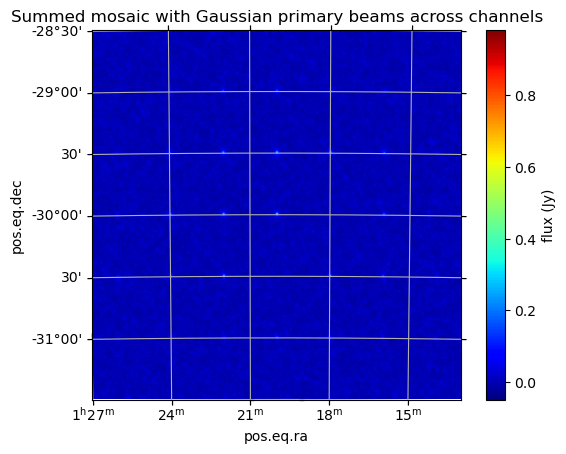

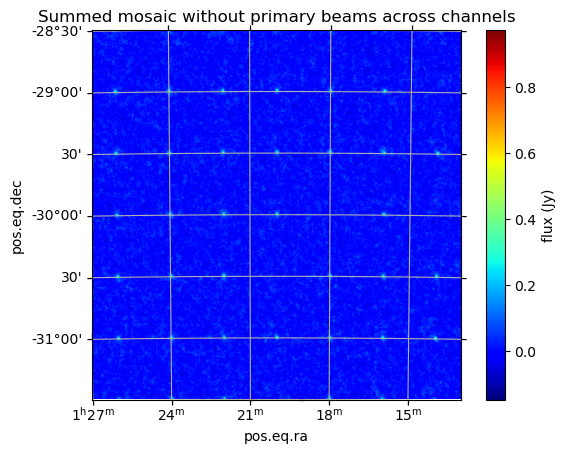

In [47]:
%matplotlib inline
backend_to_summed_mosaics_primary_beam[SimulatorBackend.RASCIL].plot(
    block=True,
    title="Summed mosaic with Gaussian primary beams across channels"
)

backend_to_summed_mosaics[SimulatorBackend.RASCIL].plot(
    block=True,
    title="Summed mosaic without primary beams across channels"
)